In [1017]:
import numpy as np
from quapack.pyRPE.classical import RobustPhaseEstimation
from quapack.pyRPE.quantum import Q as QExperiment
from scipy.linalg import expm

# definitions

In [1018]:
gellmann_matrices = [
    np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]),
    np.array([[0, 1, 0], [1, 0, 0], [0, 0, 0]]),
    np.array([[0, -1j, 0], [1j, 0, 0], [0, 0, 0]]),
    np.array([[1, 0, 0], [0, -1, 0], [0, 0, 0]]),
    np.array([[0, 0, 1], [0, 0, 0], [1, 0, 0]]),
    np.array([[0, 0, -1j], [0, 0, 0], [1j, 0, 0]]),
    np.array([[0, 0, 0], [0, 0, 1], [0, 1, 0]]),
    np.array([[0, 0, 0], [0, 0, -1j], [0, 1j, 0]]),
    np.array([[1, 0, 0], [0, 1, 0], [0, 0, -2]])
]
len(gellmann_matrices)

9

In [1019]:
single_qutrit_states = {
    '0' : np.array([1, 0, 0]), 
    '1' : np.array([0, 1, 0]),
    '2' : np.array([0, 0, 1]),
    '+01' : np.array([1, 1, 0])/np.sqrt(2),
    '+02' : np.array([1, 0, 1])/np.sqrt(2),
    '+12' : np.array([0, 1, 1])/np.sqrt(2),
    'R01' : np.array([1, 1j, 0])/np.sqrt(2),
    'R02' : np.array([1, 0, 1j])/np.sqrt(2),
    'R12' : np.array([0, 1j, 1])/np.sqrt(2),
    'nu' : np.array([0.5, 0.5, 1/np.sqrt(2)]),
    'eta' : np.array([0.5, 0.5, -1j/np.sqrt(2)]),
}


# single qutrit RPE

Consider a model 
$$
    U = \exp\left( -\frac{i}{2} \left( \theta \lambda_1 + \epsilon \lambda_3 + \gamma \lambda_8 \right)\right)
$$

We will measure 
$$
    |\langle 0| U^d |0\rangle 
$$

$$
    |\langle +_y(0,1)| U^d |0\rangle 
$$

$$
    |\langle \nu| U^d |\nu\rangle 
$$

$$
    |\langle \eta| U^d |\nu\rangle 
$$

$$
    |\langle 0| (Z U^2 Z^2 U^2 Z)^d |0\rangle 
$$

$$
    |\langle +_y(0,1)| (Z U^2 Z^2 U^2 Z)^d |0\rangle.
$$



In [1020]:
def modelX(theta, epsilon, gamma):
    return expm(-(1j/2)*(theta*(np.cos(epsilon)*gellmann_matrices[1] + np.sin(epsilon)*gellmann_matrices[3]) + gamma*gellmann_matrices[8]))

def modelZ():
    return expm(-(1j*np.pi/4)*gellmann_matrices[3])

def prob(x, circ_def):
    theta, epsilon, gamma = x
    gate, depth, prep, meas = circ_def
    if gate == 'X': 
        U = modelX(theta, epsilon, gamma)
    elif gate == 'ZXXZZXXZ':
        Uz = modelZ()
        Ux = modelX(theta, epsilon, gamma)
        U = Uz @ Ux @ Ux @ Uz @ Uz @ Ux @ Ux @ Uz
    else:
        raise NotImplementedError(f'Gate {gate} not implemented')
    prep_vec = single_qutrit_states[prep]
    meas_vec = single_qutrit_states[meas]
    return np.abs(np.dot(meas_vec, np.linalg.matrix_power(U, depth) @ prep_vec))**2

In [1021]:
def sample_at_depths(x, num_counts, gate, depths, prep, meas):
    prob_vec = np.array([prob(x, (gate, d, prep, meas)) for d in depths])
    prob_vec = np.clip(prob_vec, 0, 1)
    zero_counts = np.random.binomial(num_counts, prob_vec)
    one_counts = num_counts - zero_counts
    return {'0': zero_counts, '1': one_counts}

def make_dataset(x, depths, num_counts):
    ds = {
        'direct': {
            'cos': sample_at_depths(x, num_counts, 'X', depths, '0', '0'),
            'sin': sample_at_depths(x, num_counts, 'X', depths, 'R01', '0')
        },
        'coupling': {
            'cos': sample_at_depths(x, num_counts, 'X', depths, 'nu', 'nu'),
            'sin': sample_at_depths(x, num_counts, 'X', depths, 'eta', 'nu')
        },
        'composite': {
            'cos': sample_at_depths(x, num_counts, 'ZXXZZXXZ',  depths, '0', '0'),
            'sin': sample_at_depths(x, num_counts, 'ZXXZZXXZ', depths, 'R01', '0')
        }
    }
    return ds

def analyze_dataset_row(ds, depths):
    experiment = QExperiment()
    for idx, d in enumerate(depths):
        experiment.process_cos(d, (int(ds['cos']['0'][idx]), int(ds['cos']['1'][idx])))
        experiment.process_sin(d, (int(ds['sin']['0'][idx]), int(ds['sin']['1'][idx])))
    analysis = RobustPhaseEstimation(experiment)
    last_good_generation = analysis.check_unif_local(historical=True)
    estimates = analysis.angle_estimates
    return estimates, last_good_generation



In [1072]:
depths = [2**i for i in range(10)]
x_true = [np.pi/2+0.1, 0.12, 1]
ds = make_dataset(x_true, depths, 1000)

In [1073]:
theta_estimates, lgg = analyze_dataset_row(ds['direct'], depths)
theta_estimate = theta_estimates[lgg]
print(theta_estimate, x[0])

1.670797262703305 1.6707963267948966


In [1074]:
def rectify_angle(angle):
    """Rectify an angle to the interval [0, 2*pi)"""
    return angle % (2*np.pi)

In [1075]:
estimates, last_good_gen = analyze_dataset_row(ds['coupling'], depths) 
phi = estimates[-1]

gamma_estimate = (2*phi - theta_estimate)/3
print(gamma_estimate, x[2])

1.0000114809573202 1


In [1084]:
from scipy.optimize import root_scalar

def equation(theta, epsilon, Phi):
    # this is in the notation of III.9 of https://arxiv.org/pdf/1502.02677
    return -2*np.sin(theta)*np.sin(epsilon)*np.sqrt(1 + np.sin(theta)**2 * np.sin(epsilon)**2) + np.sin(Phi/2)


def find_theta(epsilon, Phi):
    # Define a function that takes only theta as input (for root_scalar)
    def equation_wrapper(theta):
        return equation(theta, epsilon, Phi)

    # Find the root within a suitable bracket
    result = root_scalar(equation_wrapper, x0=0)

    if result.converged:
        return result.root
    else:
        raise ValueError("Root finding did not converge.")

In [1091]:
def estimate_axis_error(composite_estimate, theta_estimate):
    return find_theta(theta_estimate, composite_estimate)

In [1092]:
estimates, last_good_gen = analyze_dataset_row(ds['composite'], depths)
estimate_phase = estimates[-1]

epsilon_estimate = estimate_axis_error(estimate_phase, theta_estimate)
print(epsilon_estimate, x_true[1])

0.11832938061474738 0.12


In [1094]:
def estimate_x_1qt(ds, depths):
    theta_estimates, lgg = analyze_dataset_row(ds['direct'], depths)
    theta_estimate = theta_estimates[lgg]
    estimates, last_good_gen = analyze_dataset_row(ds['coupling'], depths) 
    phi = estimates[-1]
    gamma_estimate = (2*phi - theta_estimate)/3
    estimates, last_good_gen = analyze_dataset_row(ds['composite'], depths)
    estimate_phase = estimates[-1]
    epsilon_estimate = estimate_axis_error(estimate_phase, theta_estimate)
    return theta_estimate, epsilon_estimate, gamma_estimate

In [1103]:
# now do it 100 times and record error
num_trials = 100
num_shots = 1000
estimates = np.zeros((num_trials, 3))
trues = np.zeros((num_trials, 3))
for i in range(num_trials):
    x_true = np.array([np.pi/2, 0, 0]) + 0.1*np.random.randn(3)
    ds = make_dataset(x_true, depths, num_shots)
    estimates[i, :] = estimate_x_1qt(ds, depths)
    trues[i, :] = x_true
estimates = np.array(estimates)
trues = np.array(trues)

In [1104]:
# mean error in each parameter
mean_error = np.mean(np.abs(estimates - trues), axis=0)
print(mean_error)

[4.28152274e-05 7.81670628e-02 3.27891146e-05]


# controlled-Z qutrit RPE

In [1107]:
def Ucz_diagonal(phis):
    return np.diag([1]+[np.exp(-1j*phi) for phi in phis])

In [1108]:
phis = np.random.randn(8)
Ucz = Ucz_diagonal(phis)

In [1109]:
state_dict = {
    '0_+01' : np.kron(single_qutrit_states['0'], single_qutrit_states['+01']),
    '0_+02' : np.kron(single_qutrit_states['0'], single_qutrit_states['+02']),
    '1_+01' : np.kron(single_qutrit_states['1'], single_qutrit_states['+01']),
    '1_+02' : np.kron(single_qutrit_states['1'], single_qutrit_states['+02']),
    '1_+12' : np.kron(single_qutrit_states['1'], single_qutrit_states['+12']),
    '2_+01' : np.kron(single_qutrit_states['2'], single_qutrit_states['+01']),
    '2_+02' : np.kron(single_qutrit_states['2'], single_qutrit_states['+02']),
    '2_+12' : np.kron(single_qutrit_states['2'], single_qutrit_states['+12']), 
    '0_R01' : np.kron(single_qutrit_states['0'], single_qutrit_states['R01']),
    '0_R02' : np.kron(single_qutrit_states['0'], single_qutrit_states['R02']),
    '1_R01' : np.kron(single_qutrit_states['1'], single_qutrit_states['R01']),
    '1_R02' : np.kron(single_qutrit_states['1'], single_qutrit_states['R02']),
    '1_R12' : np.kron(single_qutrit_states['1'], single_qutrit_states['R12']),
    '2_R01' : np.kron(single_qutrit_states['2'], single_qutrit_states['R01']),
    '2_R02' : np.kron(single_qutrit_states['2'], single_qutrit_states['R02']),
    '2_R12' : np.kron(single_qutrit_states['2'], single_qutrit_states['R12']),
    '+01_1' : np.kron(single_qutrit_states['+01'], single_qutrit_states['1']),
    '+01_2' : np.kron(single_qutrit_states['+01'], single_qutrit_states['2']),
    '+02_1' : np.kron(single_qutrit_states['+02'], single_qutrit_states['1']),
    '+12_1' : np.kron(single_qutrit_states['+12'], single_qutrit_states['1']),

    'R01_1' : np.kron(single_qutrit_states['R01'], single_qutrit_states['1']),
    'R01_2' : np.kron(single_qutrit_states['R01'], single_qutrit_states['2']),
    'R02_1' : np.kron(single_qutrit_states['R02'], single_qutrit_states['1']),
    'R12_1' : np.kron(single_qutrit_states['R12'], single_qutrit_states['1']),
}

def prob_cz(x, d, prep, meas):
    Ucz = Ucz_diagonal(x)
    prep_vec = state_dict[prep]
    meas_vec = state_dict[meas]
    return np.abs(np.dot(meas_vec, np.linalg.matrix_power(Ucz, d) @ prep_vec))**2

def sample_at_depths_cz(x, num_counts, depths, prep, meas):
    prob_vec = np.array([prob_cz(x, d, prep, meas) for d in depths])
    prob_vec = np.clip(prob_vec, 0, 1)
    zero_counts = np.random.binomial(num_counts, prob_vec)
    one_counts = num_counts - zero_counts
    return {'0': zero_counts, '1': one_counts}

def make_dataset_cz(x, depths):
    return {
        'ss0': {
            '01' :{
                'cos': sample_at_depths_cz(x, 1000, depths, '0_+01', '0_+01'),
                'sin': sample_at_depths_cz(x, 1000, depths, '0_+01', '0_R01')
            },
            '02' :{
                'cos': sample_at_depths_cz(x, 1000, depths, '0_+02', '0_+02'),
                'sin': sample_at_depths_cz(x, 1000, depths, '0_+02', '0_R02')
            }
        },
        'ss1': {
            '01': {
                'cos': sample_at_depths_cz(x, 1000, depths, '1_+01', '1_+01'),
                'sin': sample_at_depths_cz(x, 1000, depths, '1_+01', '1_R01')
            },
            '02': {
                'cos': sample_at_depths_cz(x, 1000, depths, '1_+02', '1_+02'),
                'sin': sample_at_depths_cz(x, 1000, depths, '1_+02', '1_R02')
            },
        },
        'ss2': {
            '01': {
                'cos': sample_at_depths_cz(x, 1000, depths, '2_+01', '2_+01'),
                'sin': sample_at_depths_cz(x, 1000, depths, '2_+01', '2_R01')
            },
            '02': {
                'cos': sample_at_depths_cz(x, 1000, depths, '2_+02', '2_+02'),
                'sin': sample_at_depths_cz(x, 1000, depths, '2_+02', '2_R02')
            },
        }, 
        'ss+':{
            '1': {
                'cos': sample_at_depths_cz(x, 1000, depths, '+01_1', '+01_1'),
                'sin': sample_at_depths_cz(x, 1000, depths, '+01_1', 'R01_1')
            },
            '2':{
                'cos': sample_at_depths_cz(x, 1000, depths, '+02_1', '+02_1'),
                'sin': sample_at_depths_cz(x, 1000, depths, '+02_1', 'R02_1')
            }
        }
    }

def process_ds_row(cos_counts, sin_counts, depths):
    experiment = QExperiment()
    for idx, d in enumerate(depths):
        experiment.process_cos(d, (int(cos_counts['0'][idx]), int(cos_counts['1'][idx])))
        experiment.process_sin(d, (int(sin_counts['0'][idx]), int(sin_counts['1'][idx])))
    analysis = RobustPhaseEstimation(experiment)
    last_good_generation = analysis.check_unif_local(historical=True)
    estimates = analysis.angle_estimates
    return estimates, last_good_generation

def process_dataset_cz(ds, depths):
    return {
        'ss0': {
            '01': process_ds_row(ds['ss0']['01']['cos'], ds['ss0']['01']['sin'], depths),
            '02': process_ds_row(ds['ss0']['02']['cos'], ds['ss0']['02']['sin'], depths)
        },
        'ss1': {
            '01': process_ds_row(ds['ss1']['01']['cos'], ds['ss1']['01']['sin'], depths),
            '02': process_ds_row(ds['ss1']['02']['cos'], ds['ss1']['02']['sin'], depths),
        },
        'ss2': {
            '01': process_ds_row(ds['ss2']['01']['cos'], ds['ss2']['01']['sin'], depths),
            '02': process_ds_row(ds['ss2']['02']['cos'], ds['ss2']['02']['sin'], depths),
        }, 
        'ss+':{
            '1': process_ds_row(ds['ss+']['1']['cos'], ds['ss+']['1']['sin'], depths),
            '2': process_ds_row(ds['ss+']['2']['cos'], ds['ss+']['2']['sin'], depths)
        }
    }

def recitify_angle(angle):
    """Rectify an angle to the interval [-pi, pi)"""
    return angle % (2*np.pi) - np.pi

def format_estimates_as_phases(estimates):
    phases = {}
    for ss in estimates.keys():
        phases[ss] = {}
        for key in estimates[ss].keys():
            lgg = estimates[ss][key][1]
            phases[ss][key] = recitify_angle(estimates[ss][key][0][lgg])
    return phases



In [1110]:
ds = make_dataset_cz(phis, depths)
estimates_raw = process_dataset_cz(ds, depths)
estimated_phases = format_estimates_as_phases(estimates_raw)
estimated_phases_vec = np.array([estimated_phases['ss0']['01'], estimated_phases['ss0']['02'], estimated_phases['ss1']['01'], estimated_phases['ss1']['02'], estimated_phases['ss2']['01'], estimated_phases['ss2']['02'], estimated_phases['ss+']['1'], estimated_phases['ss+']['2']])


In [1111]:
estimated_phases

{'ss0': {'01': 2.245970455304046, '02': -2.013965565507994},
 'ss1': {'01': 2.9626703043075615, '02': -2.4785699997818873},
 'ss2': {'01': -0.08665263766407305, '02': -3.064823332046913},
 'ss+': {'1': -2.710443632255624, '2': 2.184704183828929}}

In [1112]:
estimated_phases_vec
estimated_phases_vec_rectified = np.array([recitify_angle(phi) for phi in estimated_phases_vec])
print(estimated_phases_vec)
print(estimated_phases_vec_rectified)

[ 2.24597046 -2.01396557  2.9626703  -2.47857    -0.08665264 -3.06482333
 -2.71044363  2.18470418]
[-0.8956222   1.12762709 -0.17892235  0.66302265  3.05494002  0.07676932
  0.43114902 -0.95688847]


In [1113]:
phis_rectified = np.array([recitify_angle(phi) for phi in phis])
phis_rectified

array([ 2.24594305, -2.01394864,  2.85604058,  2.67717577, -2.76425871,
       -1.76591641,  1.28898374, -1.6890934 ])

In [1114]:
state_dict['+02_1']

array([0.        , 0.70710678, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.70710678, 0.        ])

In [1115]:
phis_to_estimate = np.array([
    [1, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 0, 0],
    [0, 0, -1, 1, 0, 0, 0, 0],
    [0, 0, -1, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, -1, 1, 0],
    [0, 0, 0, 0, 0, -1, 0, 1],
    [-1, 0, 0, 1, 0, 0, 0, 0],
    [-1, 0, 0, 0, 0, 0, 1, 0]
])


In [1116]:
state_dict['+02_1']

array([0.        , 0.70710678, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.70710678, 0.        ])

In [1117]:
phis

array([-0.8956496 ,  1.12764401, -0.28555207, -0.46441689,  0.37733395,
        1.37567625, -1.85260891,  1.45249925])

In [1118]:
raw_estimate = phis_to_estimate @ phis
raw_estimate

array([-0.8956496 ,  1.12764401, -0.17886481,  0.66288602, -3.22828515,
        0.07682301,  0.43123271, -0.95695931])

In [1119]:
estimated_phases_vec_rectified

array([-0.8956222 ,  1.12762709, -0.17892235,  0.66302265,  3.05494002,
        0.07676932,  0.43114902, -0.95688847])

In [1146]:
-3.228+np.pi*2

3.055185307179586

In [1120]:
estimates_to_phi = np.linalg.pinv(phis_to_estimate)

In [1121]:
# run it 100 times to verify 
num_trials = 100
estimates = np.zeros((num_trials, 8))
trues = np.zeros((num_trials, 8))
for i in range(num_trials):
    phis = np.random.randn(8)
    Ucz = Ucz_diagonal(phis)
    ds = make_dataset_cz(phis, depths)
    estimates_raw = process_dataset_cz(ds, depths)
    estimated_phases = format_estimates_as_phases(estimates_raw)
    estimated_phases_vec = np.array([estimated_phases['ss0']['01'], estimated_phases['ss0']['02'], estimated_phases['ss1']['01'], estimated_phases['ss1']['02'], estimated_phases['ss2']['01'], estimated_phases['ss2']['02'], estimated_phases['ss+']['1'], estimated_phases['ss+']['2']])
    estimates[i] = estimates_to_phi@estimated_phases_vec
    trues[i] = phis

In [1137]:
def rectify_angle(angles):
    # Rectify angles to the interval [-pi, pi)
    return (angles + np.pi) % (2*np.pi) 

def rectify_angles(angles):
    return np.array([recitify_angle(angle) for angle in angles])

In [1138]:
def cosine_similarity(x, y):
    return np.cos(x - y)

In [1139]:
cos_similarities = np.array([cosine_similarity(rectify_angles(estimates[i]), rectify_angles(trues[i])) for i in range(num_trials)])

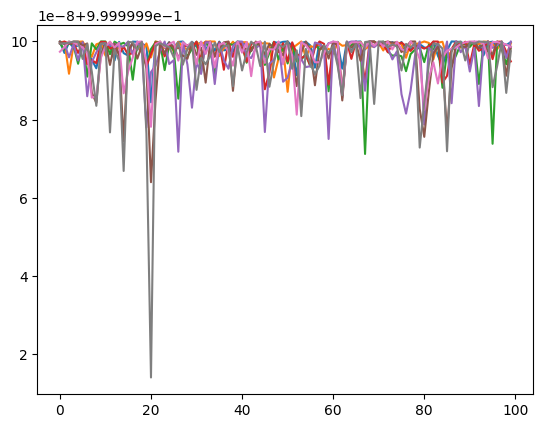

In [1140]:
plt.plot(abs(cos_similarities))

In [1141]:
errors = np.abs(rectify_angles(estimates) - rectify_angles(trues))

In [1142]:
mean_errors = np.mean(errors, axis=0)
print(mean_errors)

[3.14158970e+00 3.14160285e+00 3.14158782e+00 5.58778093e-05
 7.81343073e-05 3.14158163e+00 5.92359883e-05 7.82926956e-05]


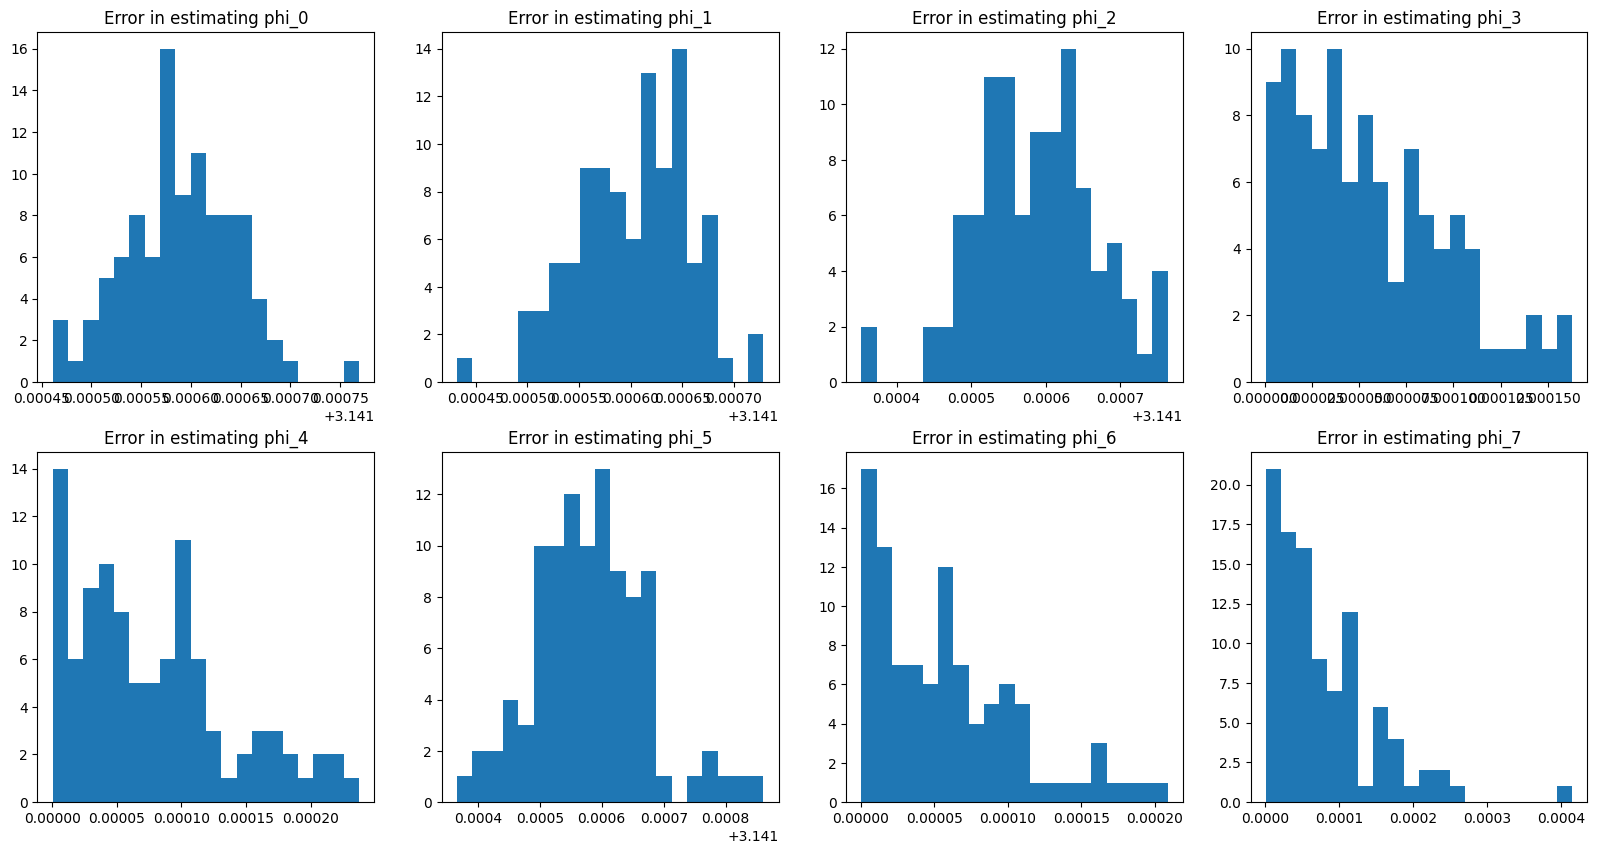

In [1143]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    ax = axs[i//4, i%4]
    ax.hist(errors[:, i], bins=20)
    ax.set_title(f'Error in estimating phi_{i}')